In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from scipy.ndimage import gaussian_filter
from scipy.stats import entropy

In [2]:
# Function to add Gaussian noise dynamically based on the step number
def add_noise(img, step, max_steps, initial_sigma=0.002, final_sigma=0.05):
    # Nonlinear scaling of noise: using exp function for a slower initial increase, better visual results
    sigma = initial_sigma + (final_sigma - initial_sigma) * (np.exp(step / max_steps * 5) - 1) / (np.exp(5) - 1)
    noise = np.random.normal(0, sigma, img.shape)
    noisy_img = img + noise
    # noisy_img = np.clip(noisy_img, 0, 1)  # Ensure pixel values are within [0, 1]
    return (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())

def calculate_entropy(img):
    histogram, _ = np.histogram(img, bins=256, range=[0,1])
    histogram_normalized = histogram / histogram.sum()
    return entropy(histogram_normalized)

def plot_histogram(img, ax):
    ax.hist(img.ravel(), bins=256, range=[0, 1], color='gray', alpha=0.75)
    ax.set_xlim([0, 1]) 
    ax.set_yticks([])

def plot_power_spectrum(img, ax):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    ax.imshow(magnitude_spectrum, cmap='gray')
    ax.axis('off')

In [3]:
img_path = 'rick.jpeg'
img = imread(img_path, mode='F') / 255.0  # Normalize pixel values to [0, 1]

/tmp/ipykernel_56827/56180233.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path, mode='F') / 255.0  # Normalize pixel values to [0, 1]


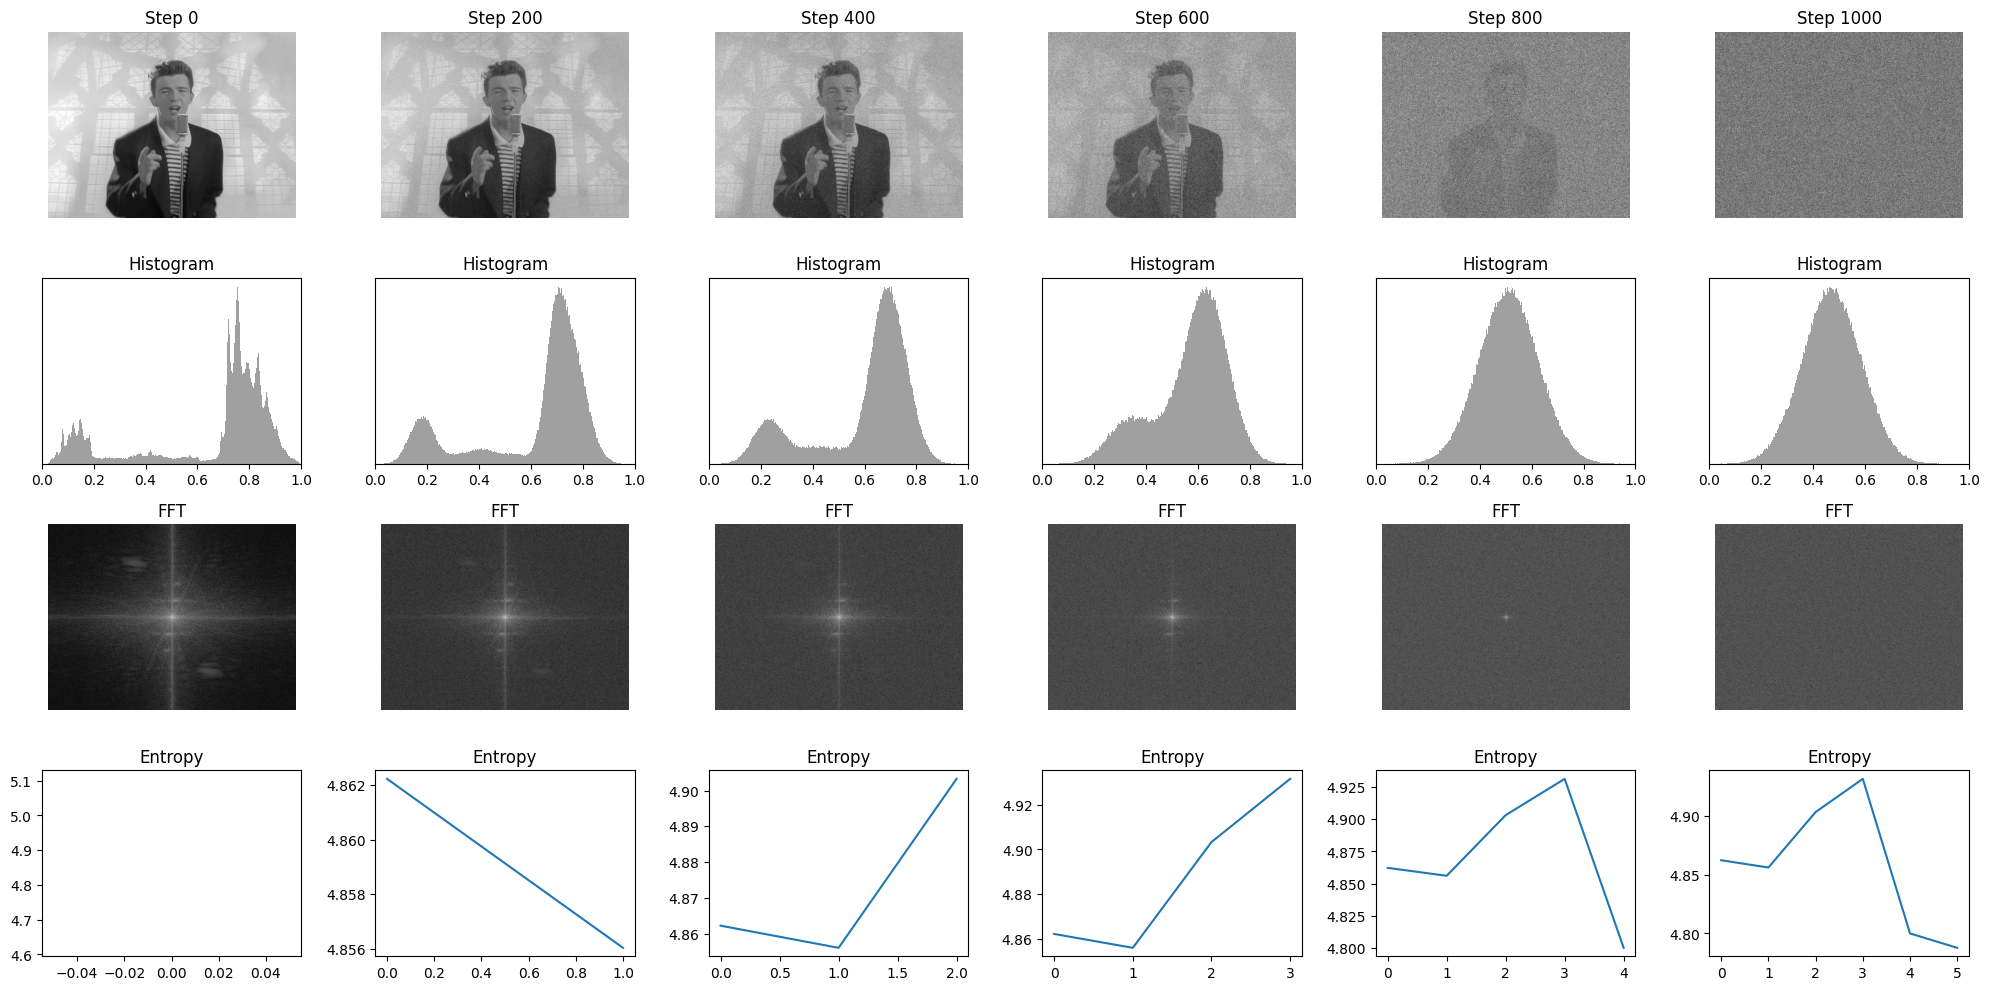

In [4]:
# Parameters
num_steps = 1000
snapshot_interval = 200

# Data collection
images = []
entropies = []
means = []
variances = []

# Diffusion process
for step in range(num_steps + 1):
    img = add_noise(img, step, num_steps)
    if step % snapshot_interval == 0:
        images.append(img.copy())
        entropies.append(calculate_entropy(img))
# Plotting
fig, axes = plt.subplots(4, len(images), figsize=(20, 10))
for i, img in enumerate(images):
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Step {i * snapshot_interval}')

    plot_histogram(img, axes[1, i])
    axes[1, i].set_title('Histogram')

    plot_power_spectrum(img, axes[2, i])
    axes[2, i].set_title('FFT')

    axes[3, i].plot(entropies[:i+1])
    axes[3, i].set_title('Entropy')

plt.tight_layout()
plt.show()